In [26]:
import numpy as np
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import shutil
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    auc,
)
from keras.utils import to_categorical

In [27]:
data_dir_train = pathlib.Path("./bird-image/train")
data_dir_test = pathlib.Path("./bird-image/test")
data_dir_valid = pathlib.Path("./bird-image/valid")

Data Prepartion:


In [28]:
# Data augmentation is used when we have limited set of input samples available. We can improve the accuracy by increasing the number of input samples
# by applying different image transformation techniques like rotating, scaling etc.

data_generator = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
)

In [29]:
samples_count = {}

# Find top 3 most frequent targets from training data.
for target in os.listdir(data_dir_train):
    target_path = os.path.join(data_dir_train, target)
    if os.path.isdir(target_path):
        samples_count[target] = len(os.listdir(target_path))

top_classes = sorted(samples_count, key=samples_count.get, reverse=True)[0:3]
print("Top classes are: ", top_classes)

# Remove samples that doesn't belong to top 3 targets from filesystem.
for curr_dir in [data_dir_train, data_dir_test, data_dir_valid]:
    for target in os.listdir(curr_dir):
        if target not in top_classes:
            path_to_remove = os.path.join(curr_dir, target)
            if os.path.isdir(path_to_remove):
                shutil.rmtree(path_to_remove)

Top classes are:  ['RUFOUS TREPE', 'HOUSE FINCH', 'D-ARNAUDS BARBET']


In [30]:
data_train = data_generator.flow_from_directory(
    data_dir_train, target_size=(180, 180), batch_size=32, class_mode="categorical"
)

data_test = data_generator.flow_from_directory(
    data_dir_test, target_size=(180, 180), batch_size=32, class_mode="categorical"
)

data_valid = data_generator.flow_from_directory(
    data_dir_valid, target_size=(180, 180), batch_size=32, class_mode="categorical"
)

Found 744 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


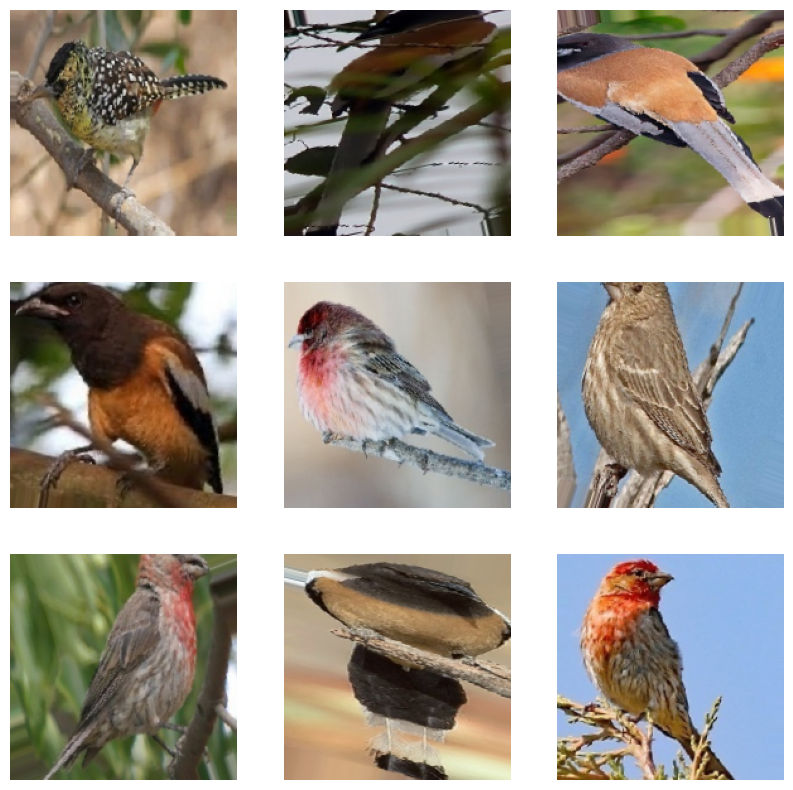

In [31]:
# Show images from first batch.
images, _ = next(data_train)

plt.figure(figsize=(10, 10))
for i in range(1, 10):
    ax = plt.subplot(3, 3, i)
    plt.imshow(images[i].astype("uint8"))
    plt.axis("off")
plt.show()  

Training:

In [32]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(180, 180, 3))
conv_base.trainable = False
conv_base.summary()

58889256/58889256 [==============================] - 11s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                             

In [33]:

# Add custom layers on`conv_base`.
x = conv_base.output
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(conv_base.input, outputs)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [34]:
# compiling and training a neural network model.
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./log/models/fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss",
    )
]
history = model.fit(
    data_train, epochs=10, validation_data=data_valid, callbacks=callbacks
)

Epoch 1/10
24/24 [==============================] - 52s 2s/step - loss: 19.7061 - accuracy: 0.4919 - val_loss: 5.4615 - val_accuracy: 0.5333
Epoch 2/10
24/24 [==============================] - 48s 2s/step - loss: 10.2425 - accuracy: 0.7070 - val_loss: 0.8880 - val_accuracy: 0.8667
Epoch 3/10
24/24 [==============================] - 49s 2s/step - loss: 6.6521 - accuracy: 0.7755 - val_loss: 0.5766 - val_accuracy: 0.9333
Epoch 4/10
24/24 [==============================] - 48s 2s/step - loss: 4.5406 - accuracy: 0.8441 - val_loss: 1.0862 - val_accuracy: 0.9333
Epoch 5/10
24/24 [==============================] - 48s 2s/step - loss: 3.5608 - accuracy: 0.8710 - val_loss: 8.6540e-06 - val_accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 47s 2s/step - loss: 3.3831 - accuracy: 0.8804 - val_loss: 1.7157 - val_accuracy: 0.9333
Epoch 7/10
24/24 [==============================] - 47s 2s/step - loss: 2.6797 - accuracy: 0.9086 - val_loss: 1.9524e-04 - val_accuracy: 1.0000
Epoch 8/10

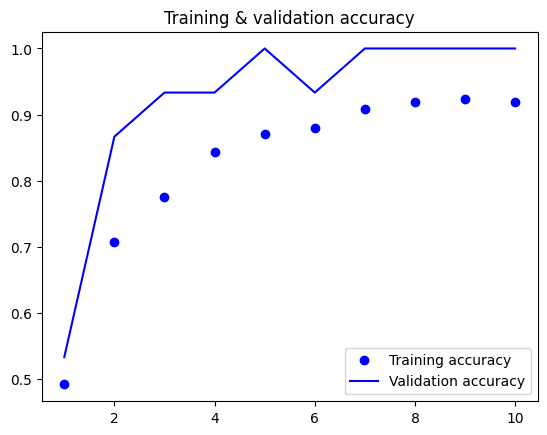

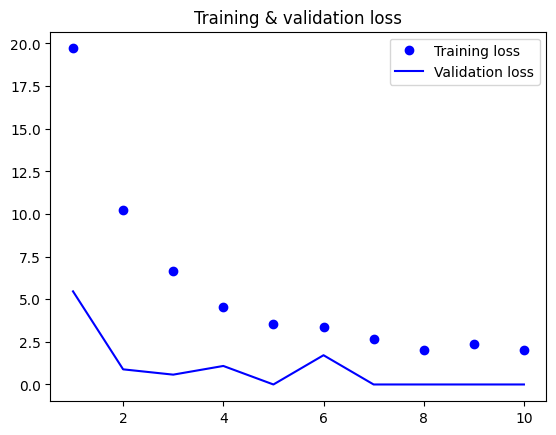

In [35]:
# Plot training metrics.

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training & validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training & validation loss")
plt.legend()
plt.show()

Evaluation:


In [36]:
# evaluating the performance of the model on a test dataset.
test_loss, test_acc = model.evaluate(data_test)
print(f"Test accuracy: {test_acc:.3f}")

1/1 [==============================] - 1s 998ms/step - loss: 2.3842e-08 - accuracy: 1.0000
Test accuracy: 1.000


In [37]:
# generating confusion metrics and classification report for the model.
y_true = data_test.classes
y_predict = model.predict(data_test)
y_pred = np.argmax(y_predict, axis=1)

print("\n___________________ CONFUSION MATRIX _______________________________")
print(confusion_matrix(y_true, y_pred))
print("\n\n___________________ REPORT _______________________________")
print(
    classification_report(y_true, y_pred, target_names=data_test.class_indices.keys()),
)

1/1 [==============================] - 1s 1s/step

___________________ CONFUSION MATRIX _______________________________
[[1 3 1]
 [2 1 2]
 [2 1 2]]


___________________ REPORT _______________________________
                  precision    recall  f1-score   support

D-ARNAUDS BARBET       0.20      0.20      0.20         5
     HOUSE FINCH       0.20      0.20      0.20         5
    RUFOUS TREPE       0.40      0.40      0.40         5

        accuracy                           0.27        15
       macro avg       0.27      0.27      0.27        15
    weighted avg       0.27      0.27      0.27        15



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


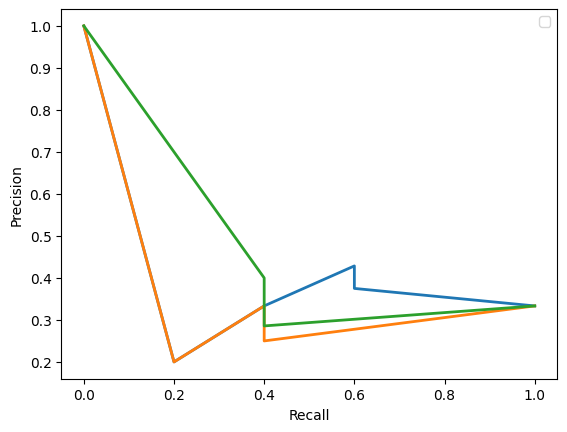

In [42]:
# Precision-Recall curve and AUC
y_true_enc = to_categorical(y_true)

for i in range(3):
    actual = y_true_enc[:, i]
    predictions = y_predict[:, i]
    precision, recall, _ = precision_recall_curve(actual, predictions)
    plt.plot(
        recall,
        precision,
        lw=2,
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

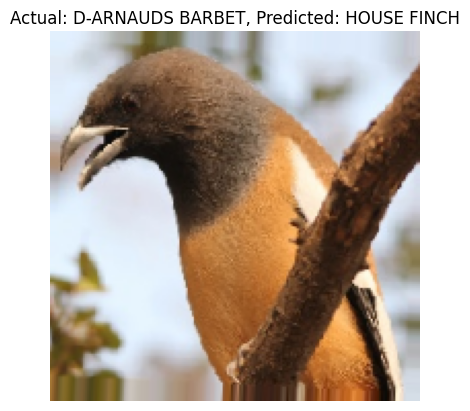

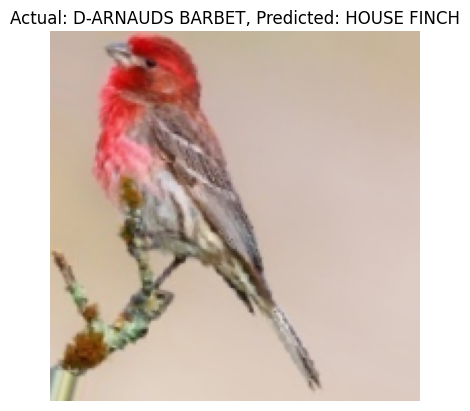

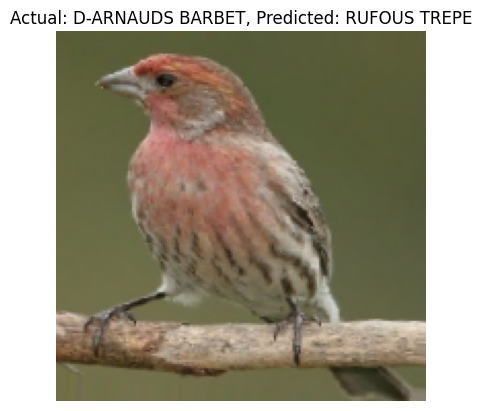

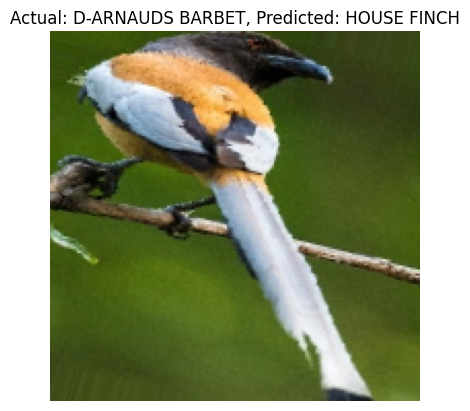

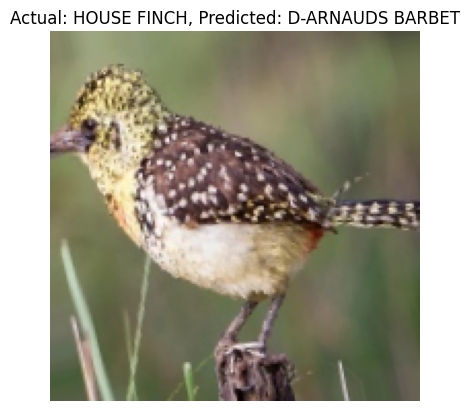

In [43]:
# Convert (label, index) tuples to {index:label} dictionary for mapping.
labels = {v: k for k, v in data_train.class_indices.items()}
# Identify misclassified samples
misclassfied_indices = np.where(y_pred != y_true)[0]


for i in misclassfied_indices[0:5]:
    # Find the batch where index belongs to.
    batch, _ = data_test[i // data_test.batch_size]
    img = batch[i % data_test.batch_size]  # Get image at index inside batch
    plt.imshow(img.astype("uint8"))
    plt.title(f"Actual: {labels[y_true[i]]}, Predicted: {labels[y_pred[i]]}")
    plt.axis("off")
    plt.show()

From the misclassified sample images, it looks like the actual labels of the images were wrong in the first place. The species looks different from each other.
